## Imports

In [21]:
from pennylane import numpy as np
import scipy
import pennylane as qml
import matplotlib.pyplot as plt
import torch
from itertools import product

## Loss function

In [3]:
def mmr_newton(data, k, convergence=1e-6, verbose=False):
    x_data = torch.tensor(data[0])
    y_data = np.array(data[1])
    
    k_evaluated_at_data_points = np.zeros((len(x_data), len(x_data)))
    for i in range(len(x_data)):
        for j in range(len(x_data)):
            k_evaluated_at_data_points[i, j] = k(x_data[i], y_data[j])
    
    def trial_function_evaluated_at_data_points(a, b):
        result = np.zeros_like(a)
        result += b
        for i in range(len(a)):
            result += a[i]*k_evaluated_at_data_points[:, i]
        return result
    
    def trial_function(x, a, b):
        result=b
        for i in range(len(a)):
            result += a[i]*k(x, y_data[i])
        return result
    
    def loss_function(alphas):
        b = alphas[0]
        a = alphas[1:]
        y_trial = trial_function_evaluated_at_data_points(a, b)
        result = np.sum((y_data-y_trial)**2)
        return result
    
    x0 = np.array([np.sum(x_data)/len(x_data), *np.zeros_like(y_data)], requires_grad=True)
    
    minimization, losses = newton(loss_function, x0, iteration=100, convergence=convergence, verbose=verbose)
    minimization = minimization.clone().detach().numpy()
    
    b = minimization[0]
    a = minimization[1:]
    
    def optimized_trial_function(x):
        return trial_function(x, a, b)
    
    return optimized_trial_function, losses


def mmr_DE_newton(DE, data, x0, f0, k, verbose=False):
    x_data = np.array(data[0])
    y_data = np.array(data[1])
    
    k_at_initial_condition = np.zeros(len(x_data))
    for i in range(len(x_data)):
        k_at_initial_condition[i] = k(x0, y_data[i])

    def f0_trial(a, b):
        result = 0
        result += b
        for i in range(len(a)): 
            result += a[i]*k_at_initial_condition[i]
        return result

    k_evaluated_at_data_points = np.zeros((len(x_data), len(x_data)))
    dk_dx_evaluated_at_data_points = np.zeros((len(x_data), len(x_data)))
    for i in range(len(x_data)):
        for j in range(len(x_data)):
            
            x_i = x_data[i].clone().detach().requires_grad_(True)
            out = k(x_i, y_data[j])
            out.backward()

            dk_dx_evaluated_at_data_points[i, j] = x_i.grad
            k_evaluated_at_data_points[i, j] = out.clone().detach()

    def trial_function_evaluated_at_data_points(a, b):
        result = np.zeros_like(a)
        result += b
        for i in range(len(a)): 
            result += a[i]*k_evaluated_at_data_points[:, i]
        return result
    
    def dx_trial_function_evaluated_at_data_points(a, b):
        result = np.zeros_like(a)
        for i in range(len(a)): 
            result += a[i]*dk_dx_evaluated_at_data_points[:, i]
        return result
    
    def trial_function(x, a, b):
        result=b
        for i in range(len(a)):
            result += a[i]*k(x, y_data[i])
        return result
    
    def loss_function(alphas):
        b = alphas[0]
        a = alphas[1:]
        result = (f0-f0_trial(a, b))**2
        f_trial = trial_function_evaluated_at_data_points(a, b)
        df_dx_trial = dx_trial_function_evaluated_at_data_points(a, b)
        for i in range(len(x_data)):
            result += DE(x_data[i], f_trial[i], df_dx_trial[i])**2
        return result
    
    x0 = np.array([np.sum(y_data)/len(y_data), *np.zeros_like(y_data)], requires_grad=True)
    minimization, losses = newton(loss_function, x0, verbose=verbose)
    minimization = minimization.clone().detach().numpy()
    
    b = minimization[0]
    a = minimization[1:]
    
    def optimized_trial_function(x):
        return trial_function(x, a, b)
    
    return optimized_trial_function
    

### Multivalued

In [102]:
def multivalued_mmr_DE_newton(DE, data, x0, f0, K):
    x_data = np.array(data[0])
    y_data = np.array(data[1])
    x0 = np.array(x0)
    f0 = np.array(f0)
    #f: R^n -> R^m
    #kernel evaluation points: n_x and n_y points in R^n / R^m respectively
    n = len(x0)
    m = len(f0)
    n_x = len(x_data)
    n_y =len(y_data)

    a0 = np.array([*np.sum(y_data, axis=0) / y_data.shape[0], *np.zeros(m*n*n_y)], requires_grad=True)
    
    def K_grad(x, y):
        params = np.array([x, y], requires_grad=True)
        return qml.jacobian(K, argnum=[0])(params[0], params[1])[0]
        
    k_at_initial_condition = np.zeros((n, n_y, m))
    for (i, j, k) in product(range(n), range(n_y), range(m)):
        k_at_initial_condition[i, j, k] = K(x0[i], y_data[j, k])

    def f0_trial(a, b):
        result = np.array([b[i] + a[i, j, k, l]*k_at_initial_condition[j, k, l] for i, j, k, l in product(range(m), range(n), range(n_y), range(m))])
        return result.sum(axis=0)

    k_evaluated_at_data_points = np.zeros((n_x, n, n_y, m))
    dk_dx_evaluated_at_data_points = np.zeros((n_x, n, n_y, m))
    for i, j, k, l in product(range(n_x), range(n), range(n_y), range(m)):
        x_ij = x_data[i, j]
        dk_dx_evaluated_at_data_points[i, j, k, l] = K_grad(x_ij, y_data[k, l])
        k_evaluated_at_data_points[i, j, k, l] =  K(x_ij, y_data[k, l])

    def trial_function_evaluated_at_data_points(a, b):
        result = np.array([
            b[j] + sum(a[j, k, l, o] * k_evaluated_at_data_points[i, k, l, o]
                        for k, l, o in product(range(n), range(n_y), range(m)))
            for i, j in product(range(n_x), range(m))
        ]).reshape((n_x, m))
        return result
    

    def dx_trial_function_evaluated_at_data_points(a, b):
        result = np.array([
            sum(a[j, k, l, o] * dk_dx_evaluated_at_data_points[i, k, l, o]
                for k, l, o in product(range(n), range(n_y), range(m)))
            for i, j in product(range(n_x), range(m))
        ]).reshape((n_x, m))
        return result

    def trial_function(x, a, b):
        result = np.array([a[i, j, k, l]*K(x[j], y_data[k, l])
                           for i, j, k, l in product(range(m), range(n), range(n_y), range(m))])
        return result.sum(axis=0) + b

    def loss_function(alphas):
        b = alphas[:m]
        a = np.reshape(alphas[m:], (m, n, n_y, m))
        result = np.linalg.norm((f0-f0_trial(a, b)))**2
        f_trial = trial_function_evaluated_at_data_points(a, b)
        df_dx_trial = dx_trial_function_evaluated_at_data_points(a, b)
        for i in range(len(x_data)):
            result += np.linalg.norm(DE(x_data[i], f_trial[i], df_dx_trial[i]))**2
        return result
    
    #a0 = np.array([*np.sum(y_data, axis=0)/y_data.shape[0], *np.zeros(m*n*n_y*m)], requires_grad=True)

    def grad_function(alphas):
        alphas = np.array(alphas, requires_grad=True)
        return qml.jacobian(loss_function)(alphas)

    minimization = scipy.optimize.minimize(
        loss_function, a0, jac=grad_function, method='Newton-CG', callback=None, options={'disp':True}).x

    b = minimization[:m]
    a = np.array(minimization[m:])
    a = np.reshape(a, (m, n, n_y, m))

    def optimized_trial_function(x):
        return trial_function(x, a, b)

    
    return loss_function
    #return optimized_trial_function


## Kernel

### Kernel library

In [97]:
from pennylane.templates import BasicEntanglerLayers, AngleEmbedding, StronglyEntanglingLayers

#classical kernel, k(x, y) = exp(-(x-y)**2/(2*sigma**2))
def K_classical(sigma):
    def k(x, y):
        return np.exp(-(x-y)**2/(2*sigma**2))
    return k

def make_kernel(U, N):
    def k(x, y):
        @qml.qnode(qml.device('default.qubit', wires=N), interface="autograd")
        def kernel_circuit(x, y):
            U(y)
            qml.adjoint(U)(x)
            return qml.probs(wires=range(N))
        
        return kernel_circuit(x, y)[0]
    
    return k

#quantum kernel with a single Rx gate on every qubit as a feature map
def K_simple_RX(N):
    def U(x):
        for n in range(N):
            qml.RX(x, wires=n)

    return make_kernel(U, N)

def K_layered(N, n_layers):
    def phi(x, q):
        return q * x / 2

    def U(x):
        
        def U_x():
            for n in range(N):
                qml.RX(phi(x, n), wires=n)
                
        for layer in range(n_layers):
            for wire in range(N):
                qml.RY(phi(x, wire), wires=wire)
            
            U_x()
            
            # If last layer, no entangler
            if layer == n_layers-1:
                continue
                
            # CNOT entangler (alternate for each layer)
            if layer % 2 == 0:
                for wire in range(0, N-1, 2):
                    qml.CNOT(wires=[wire, wire+1])
            else:
                for wire in range(1, N-1, 2):
                    qml.CNOT(wires=[wire, wire+1])
                
                qml.CNOT(wires=[N-1, 0])
            
        
    return make_kernel(U, N)

def K_phi_RX(N):
    def phi(x, q):
        return q*x/2
    def U(x):
        for n in range(N):
            qml.RX(phi(x, n), wires=n)
    
    return make_kernel(U, N)

### Visualize Kernel

In [6]:
def kernel_subplot(ax, k, N, grid_res=15):
    xs = np.linspace(0, 2*np.pi, grid_res)
    KK = np.array([[k(x, y) for x in xs] for y in xs])

    ax.set_title(rf"$\kappa(x, y)$ for $N={N}$ qubits")
    ax.imshow(KK, extent=(0, 2*np.pi, 0, 2*np.pi))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])
    
def loss_plot(lossesArray, labels=None):
    for i, losses in enumerate(lossesArray):
        label = labels[i] if labels is not None else f"loss {i}"
        plt.plot(losses, label=label)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.yscale("log")
    plt.legend()
    plt.show()

def compare_plot(f_opt, f_sol, data, xs):
    x = data[0]
    y = data[1]
    plt.plot(x, y, "x", label="data", color="black", alpha=0.5)
    plt.plot(xs, [f_sol(x) for x in xs], label="analytic")
    plt.plot(xs, [f_opt(x) for x in xs], label="opt", linestyle="--")
    plt.ylabel("f(x)")
    plt.xlabel("x")
    plt.legend()
    plt.show()

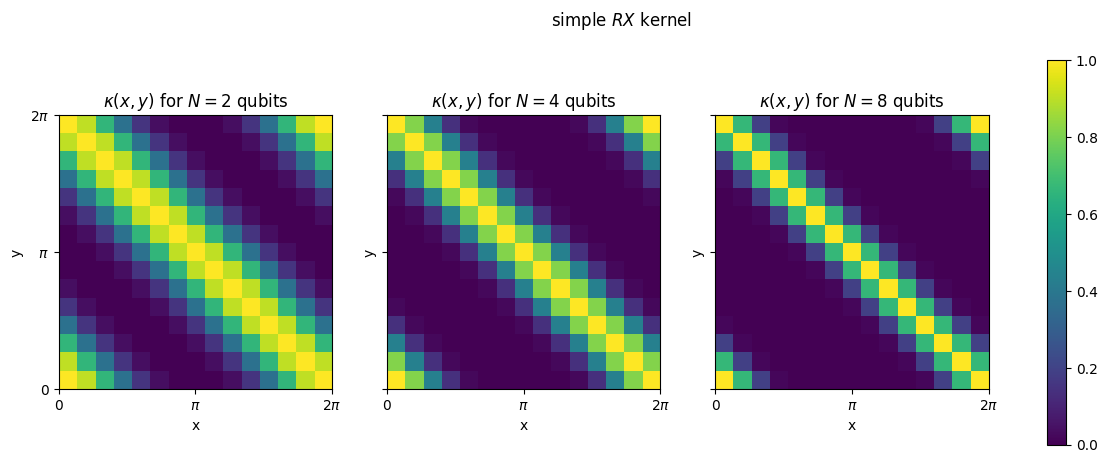

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle(r"simple $RX$ kernel")
k = K_simple_RX(2)
kernel_subplot(axs[0], k, 2)
k = K_simple_RX(4)
kernel_subplot(axs[1], k, 4)
k = K_simple_RX(8)
kernel_subplot(axs[2], k, 8)
# colorbar
fig.colorbar(axs[2].images[0], ax=axs, orientation="vertical")
plt.show()

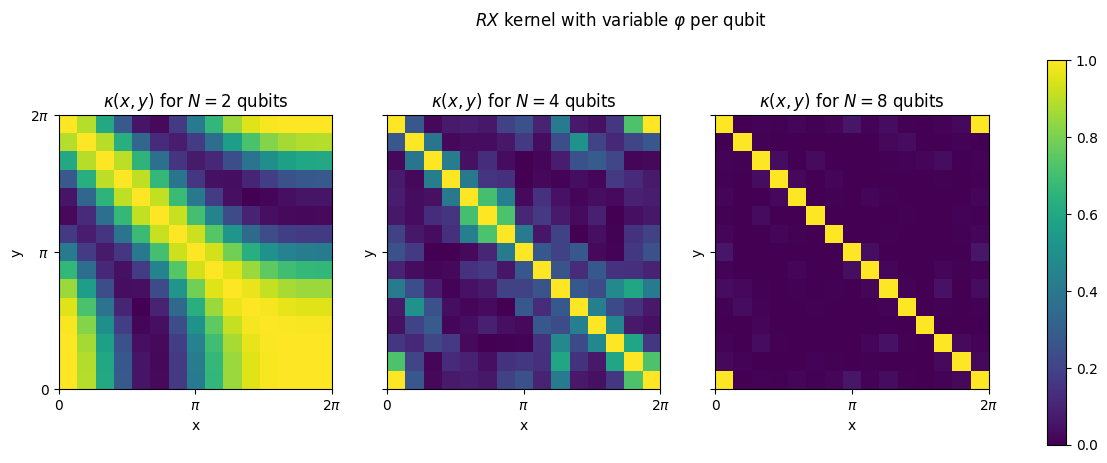

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle(r"$RX$ kernel with variable $\varphi$ per qubit")
k = K_layered(2, n_layers=2)
kernel_subplot(axs[0], k, 2)
k = K_layered(4, n_layers=2)
kernel_subplot(axs[1], k, 4)
k = K_layered(8, n_layers=2)
kernel_subplot(axs[2], k, 8)
# colorbar
fig.colorbar(axs[2].images[0], ax=axs, orientation="vertical")
plt.show()

## Results

### $f(x) = x^2$

In [9]:
x = np.linspace(0, 0.1, 51)
y = x**2
data = np.array([x, y])

In [10]:
k = K_classical(0.14)
f,_ = mmr_newton(data, k)

compare_plot(f, lambda x: x**2, data, xs=np.linspace(0, 0.1, 100))

TypeError: newton() got an unexpected keyword argument 'iteration'

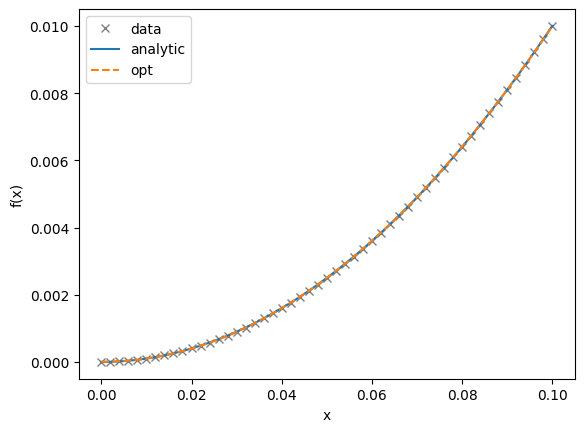

In [9]:
k = K_simple_RX(8)
f,_ = mmr_newton(data, k)

compare_plot(f, lambda x: x**2, data, xs=np.linspace(0, 0.1, 100))

### $f(x) = \exp(x)$

In [10]:
x = np.linspace(0, 5.0, 51)
y = np.exp(x)
data = np.array([x, y])

In [11]:
k = K_classical(0.14)
try:
    f,_ = mmr_newton(data, k)
    plt.plot(x, y, label="trial")
    plt.plot(x, np.array([f(x) for x in x]), label="original")

except RuntimeError as e:
    print(e)

linalg.inv: The diagonal element 22 is zero, the inversion could not be completed because the input matrix is singular.


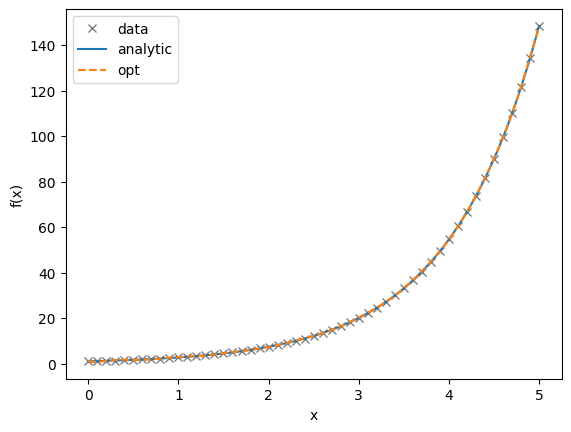

In [12]:
k = K_simple_RX(8)
f, lossesQK = mmr_newton(data, k)

compare_plot(f, np.exp, data, xs=np.linspace(0, 5, 100))

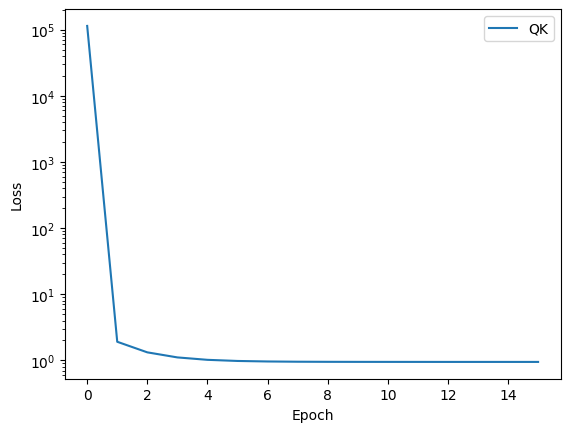

In [13]:
loss_plot([lossesQK], labels=["QK"])

### $\frac{df}{dx} = -\lambda \kappa f - \lambda \exp(\lambda \kappa x)\sin(\lambda x)$

with Solution: $f_{sol}(x) = -\lambda \exp(-\lambda \kappa x)\cos(\lambda x)$

In [23]:
def make_DE(llambda, kk):
    def df_dx(x, f, l, k):
        return -l * k * f -l * np.exp(-l * k * x) * np.sin(l * x)
    
    def DE(x, f, dfdx):
        return dfdx - df_dx(x, f, llambda, kk)

    def f_sol(x):
        return np.exp(-llambda * kk * x) * np.cos(llambda * x)
    
    return DE, f_sol

llambda = 20
kk = 0.1

DE, sol = make_DE(llambda, kk)

In [55]:
x = np.linspace(0, 1, 21)
y = x

k = K_layered(8, n_layers=5)
f = mmr_DE_newton(DE, [x, y], 0, 1, k, verbose=True)

/Users/moritz/anaconda3/envs/AQA_project/lib/python3.12/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Loss: 1030.3576076078064
Loss: 633.7945551879876
Loss: 36.19221649751423
Loss: 22.170274682171428
Loss: 5.706456044176653
Loss: 7.9233465996369254
Loss: 3.4599525500697235
Loss: 3.1368071074858586
Loss: 2.0896230829551796
Loss: 1.590008521123854
Loss: 1.4616839746456725
Loss: 1.0132484982036418
Loss: 0.9036127945327392
Loss: 0.7262784505811883
Loss: 0.6439820234906749
Loss: 0.5825230566010599
Loss: 0.5449497879152523
Loss: 0.42594168353503287
Loss: 0.4063902368068205
Loss: 0.3203629804654951
Loss: 0.30319978706724693
Loss: 0.2948774768673566
Loss: 0.2836836504831425
Loss: 0.2626136121837355
Loss: 0.2861879286888816
Loss: 0.24768187236680642
Loss: 0.2443553003547955
Loss: 0.23588399753500022
Loss: 0.22952742005540755
Loss: 0.22067058091762543
Loss: 0.20594205957925354
Loss: 0.18890900801056293
Loss: 0.16412942465791244
Loss: 0.1499325937121867
Loss: 0.1368542662978454
Loss: 0.13558208185486054
Loss: 0.1353213964986056
Loss: 0.13428404247163642
Loss: 0.13237727449878403
Loss: 0.128462319

In [103]:
x = np.linspace(0, 1, 21).reshape(21, 1)
y = x

k = K_layered(8, n_layers=8)
f_m = multivalued_mmr_DE_newton(DE, [x, y], np.array([0.]), np.array([1.]), k)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 241
         Hessian evaluations: 0


In [104]:
x_data = np.array(x)
y_data = np.array(y)
x0 = np.array([0.])
f0 = np.array([1.])
#f: R^n -> R^m
#kernel evaluation points: n_x and n_y points in R^n / R^m respectively
n = len(x0)
m = len(f0)
n_x = len(x_data)
n_y =len(y_data)

a0 = np.array([*np.sum(y_data, axis=0) / y_data.shape[0], *np.zeros(m*n*n_y)], requires_grad=True)
qml.jacobian(f_m)(a0)

array([ 555.30769144, -485.26921275, -255.37826699,  555.2187549 ,
        900.23666438,  472.70335199, -271.2499341 , -653.17786658,
       -428.15901661,  135.78900707,  494.00991847,  376.54224354,
        -13.82087359, -320.32017749, -289.51140069,   12.69486937,
        260.28653902,  242.61757137,   33.08903908, -130.93101488,
       -113.41577077,    3.77802657])

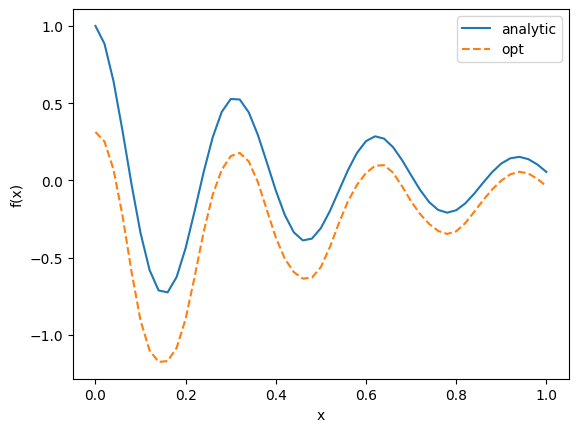

In [101]:
x = np.linspace(0, 1, 51)
y = x
xs = np.reshape(x, (len(x), -1))
plt.plot(xs, [sol(x) for x in xs], label="analytic")
plt.plot(xs, [f_m(x) for x in xs], label="opt", linestyle="--")
plt.ylabel("f(x)")
plt.xlabel("x")
plt.legend()
plt.show()